In [122]:
import numpy as np
import pandas as pd

from itertools import combinations 
from sklearn.model_selection import train_test_split
from scipy import stats

from gmr import GMM

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.datasets import load_iris, load_wine, load_digits
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import preprocessing

In [92]:
df = pd.read_csv('./datasets/vowel.csv', sep=',')

df['target'] = df['target'].astype(int)

In [10]:
def pdf_gmm(x, weights, means, covs):
    p = 0
    for i in range(len(weights)):
        p += weights[i] * stats.multivariate_normal.pdf(x, mean=means[i], cov=covs[i], allow_singular=True)
    return p

def olr (w, means, covs):
    n_comp = len(w)
    olr_values = []
    for i in range(n_comp):
        for j in range(i+1, n_comp, 1):
            delta = (np.array(means[j]) - np.array(means[i])) * 1/1000
            points = [np.array(means[i]) - 10*delta]
            current_point = np.array(means[i]) - 10*delta
            for k in range(1030):
                new_point = current_point + delta
                current_point = new_point
                points.append(new_point)
            w1 = w[i]
            w2 = w[j]
            w1_new = w1 / (w1 + w2)
            w2_new = 1 - w1_new
            w_new = [w1_new, w2_new]
            m_new = [means[i], means[j]]
            cov_new = [covs[i], covs[j]]
            peaks = []
            saddles = []
            for k in range(1, 1030, 1):
                pdf_k = pdf_gmm(points[k], w_new, m_new, cov_new)
                pdf_prev_k = pdf_gmm(points[k-1], w_new, m_new, cov_new)
                pdf_next_k = pdf_gmm(points[k+1], w_new, m_new, cov_new)
                if ((pdf_k - pdf_prev_k) > 0) & ((pdf_k - pdf_next_k) > 0):
                    peaks.append(pdf_k)
                if (((pdf_k - pdf_prev_k) < 0) & ((pdf_k - pdf_next_k) < 0)) | (((pdf_k - pdf_prev_k) == 0) & ((pdf_k - pdf_next_k) == 0)):
                #if ((pdf_k - pdf_prev_k) < 0) & ((pdf_k - pdf_next_k) < 0):
                    saddles.append(pdf_k)
            olr_current = 0
            if len(peaks) == 1:
                olr_current = 1
            else:
                olr_current = saddles[0] / np.min(peaks)
            olr_values.append(olr_current)
    return np.mean(olr_values)

In [168]:
def possible_variations(classes):
    variations = []
    
    for c_i in classes:
        for c_j in classes:
            if c_i != c_j:
                variations.append([c_i, c_j])
    
    return variations

def explode_cluster(data, target, clusters):
    indices_0_1 = [idx for idx, x in enumerate(target) if x in clusters]
    
    return [data[idx] for idx in indices_0_1], [target[idx] for idx in indices_0_1]

def load_dataset(X, y, meta: dict):
    clusters = []
    classes = list(set(y))
    for c in combinations(classes, 2):
        if 'exclude' in meta and c in meta['exclude']:
            continue
        
        X_c, y_c = explode_cluster(X, y, c)
  
        cluster = train_test_split(X_c, y_c, test_size=0.25, random_state=0)
        cluster.append(c)
        
        clusters.append(cluster)
    
    return {
        'clusters': clusters,
        'meta': meta
    }

def load_dataset_iris():
    iris = load_iris()
    
    return load_dataset(iris.data, iris.target, {
        'label': 'Iris',
        'color': 'blue',
        'marker': 'o'
    })

def load_dataset_wine():
    wine = load_wine()
    
    return load_dataset(wine.data, wine.target, {'label': 'Wine', 'color': 'orange', 'marker': 's'})

def load_dataset_from_file(filename: str, predictors: list[str], target: str, meta: dict) -> any:
    df = pd.read_csv(f'./datasets/{filename}.csv')
    df[target] = df[target].astype(int)
    
    X = df[predictors].to_numpy()
    y = df[target].to_numpy()
    
    return load_dataset(X, y, meta)

In [260]:
datasets = [
    load_dataset_iris(),
    load_dataset_wine(),
    
    # https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html
    # An application on traffic light signals from Georges Bonga at University of Applied Sciences, Berlin
    load_dataset_from_file('svmguide4', predictors=['0', '1', '2'], target='target', meta={
        'exclude': [(2, 3), (-2, -3), (1, -2), (2, -2), (1, 2), (1, -3)],
        'label': 'Svmguide4',
        'color': 'red',
        'marker': 'o'
    }),
    # Glass Identification
    load_dataset_from_file('glass', predictors=['2', '4'], target='target', meta={
        'exclude': [(5, 6), (2, 5), (2, 6), (2, 3)],
        'label': 'Glass',
        'color': 'green',
        'marker': 's'
    }),
    load_dataset_from_file('vehicle', predictors=['6', '9', '10', '12'], target='target', meta={
        'exclude': [(1, 2), (3, 4)],
        'label': 'Vehicle',
        'color': 'black',
        'marker': '*',
        'alpha': 0.6
    })
]

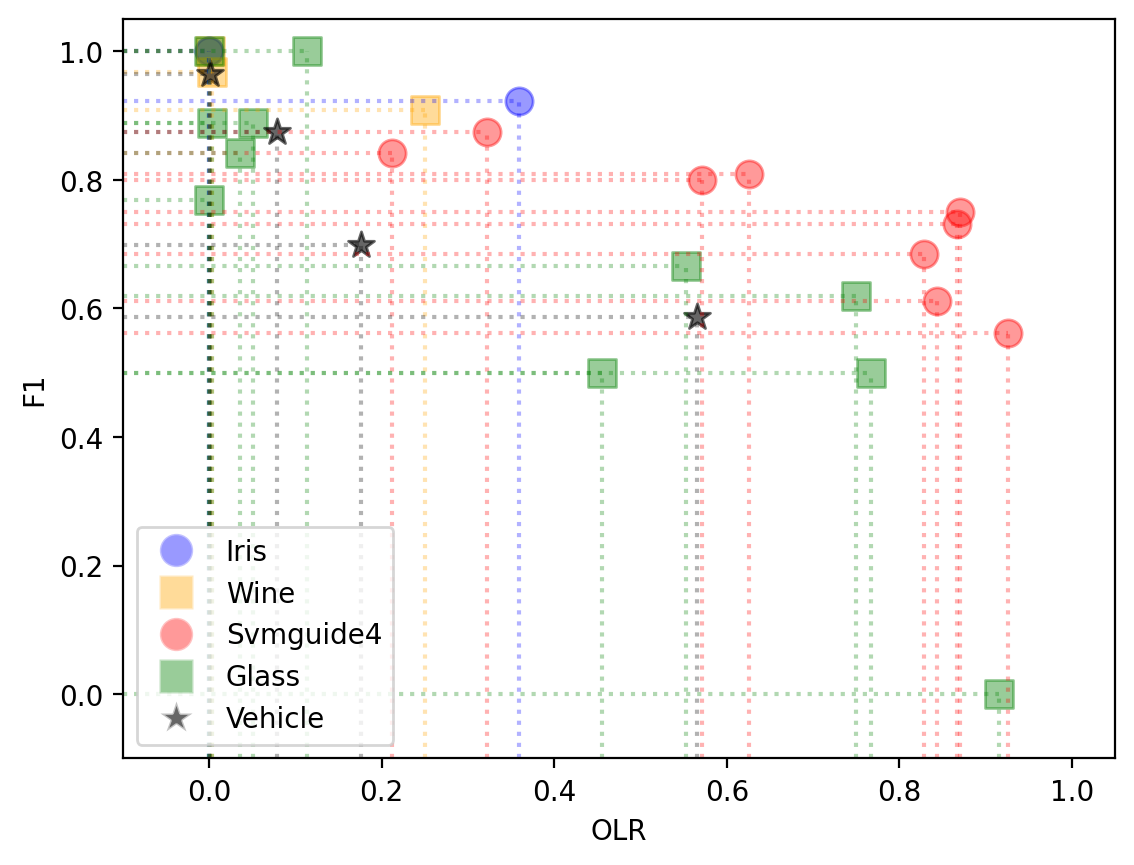

In [266]:
plt.rcParams['figure.dpi'] = 200

legend_elements = []
scores = []
olrs = []

fig, ax = plt.subplots()

for dataset in datasets:
    clusters = dataset['clusters']
    meta = dataset['meta']
    
    alpha = meta['alpha'] if 'alpha' in meta else 0.4
    
    for cluster in clusters:
        X_train, X_test, y_train, y_test, classes = cluster
        
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)
        
        f1 = f1_score(model.predict(X_test), y_test, pos_label=classes[-1])
        scores.append(f1)
        
        arr = np.array(X_train)
        df = pd.DataFrame(arr)

        gmm = GMM(n_components=2, random_state=0)
        gmm.from_samples(arr)

        w = gmm.priors
        means = gmm.means
        cov = gmm.covariances
        
        o = olr(w, means, cov)
        olrs.append(o)
        
        ax.scatter(o, f1, c=meta['color'], alpha=alpha, s=96, marker=meta['marker'])

        ax.vlines(o, -0.1, f1, color=meta['color'], linestyles='dotted', alpha=0.3)
        ax.hlines(f1, -0.1, o, color=meta['color'], linestyles='dotted', alpha=0.3)
        
#         ax.annotate(str(classes), (o, f1))
    
    legend_elements.append(Line2D([0], [0], marker=meta['marker'], color='w', label=meta['label'],
                          markerfacecolor=meta['color'], alpha=alpha, markersize=12))


plt.xlim([-0.1, 1.05])
plt.ylim([-0.1, 1.05])
plt.legend(handles=legend_elements)
plt.xlabel('OLR')
plt.ylabel('F1')
plt.show()

# еще данные

In [267]:
# задавать стартовое значение средних в GMM, посчитанное на данных
# в sklearn